In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Concatenate, Activation
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt

In [28]:
class DataGenerator(Sequence):
    def __init__(self, audio_dir, label_dir, batch_size=16, segment_duration=2.0, sr=22050, bins_per_semitone=3, hop_size=0.011, fmin=27.5, midi_min=21, num_semitones=88, n_output_freqs=33, **kwargs):
        """
        Data generator for segmented audio files and labels.
        """
        super().__init__(**kwargs)
        self.audio_dir = audio_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.segment_duration = segment_duration
        self.sr = sr
        self.bins_per_semitone = bins_per_semitone
        self.hop_size = hop_size
        self.fmin = fmin
        self.midi_min = midi_min
        self.num_semitones = num_semitones
        self.bins_per_octave = bins_per_semitone * 12
        self.n_output_freqs = n_output_freqs  # Nombre de bins en sortie après stacking
        self.segment_num_frames = int(segment_duration / hop_size)

        # List of audio files
        self.audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith('.wav')])

    def __len__(self):
        """Number of batches per epoch."""
        total_segments = sum(self.num_segments_per_audio(audio_file) for audio_file in self.audio_files)
        return int(np.ceil(total_segments / self.batch_size))

    def num_segments_per_audio(self, audio_file):
        """Calculate the number of segments for a specific audio file."""
        audio_path = os.path.join(self.audio_dir, audio_file)
        duration = librosa.get_duration(path=audio_path)
        return int(np.ceil(duration / self.segment_duration))

    def flatten_harmonic_cqt(self, harmonic_cqt):
        """
        Combine harmonic channels into a single channel by flattening the harmonic axis.
        """
        freq, time, harmonics = harmonic_cqt.shape
        flattened_cqt = harmonic_cqt.reshape(freq * harmonics, time)
        return flattened_cqt

    def compute_harmonic_cqt(self, audio, num_frames):
        """
        Compute the CQT and apply harmonic stacking with normalization, including sub-harmonic.
        """
        target_length = int(self.segment_duration * self.sr)
        if len(audio) < target_length:
            padding = np.zeros(target_length - len(audio))
            audio = np.hstack((audio, padding))

        n_bins = self.num_semitones * self.bins_per_semitone
        cqt = librosa.cqt(audio, sr=self.sr, hop_length=int(self.hop_size * self.sr),
                          n_bins=n_bins, bins_per_octave=self.bins_per_octave, fmin=self.fmin)
        cqt = np.abs(cqt)

        harmonics = [0.5] + list(range(1, 8))  # Sous-harmonique et 7 harmoniques
        harmonic_cqt = []
        for h in harmonics:
            shift = int(h * self.bins_per_semitone)
            if h < 1:  # Sous-harmonique
                shifted_cqt = np.roll(cqt, shift=-shift, axis=0)
            else:  # Harmoniques
                shifted_cqt = np.roll(cqt, shift=shift, axis=0)
            harmonic_cqt.append(shifted_cqt)

        harmonic_cqt = np.stack(harmonic_cqt, axis=-1)

        # Réduire à n_output_freqs en tronquant les fréquences
        harmonic_cqt = harmonic_cqt[:self.n_output_freqs, :, :]

        if harmonic_cqt.shape[1] < num_frames:
            padding = np.zeros((harmonic_cqt.shape[0], num_frames - harmonic_cqt.shape[1], harmonic_cqt.shape[2]))
            harmonic_cqt = np.concatenate((harmonic_cqt, padding), axis=1)
        elif harmonic_cqt.shape[1] > num_frames:
            harmonic_cqt = harmonic_cqt[:, :num_frames, :]

        harmonic_cqt = np.log1p(harmonic_cqt)
        harmonic_cqt /= np.max(harmonic_cqt)

        harmonic_cqt_flattened = self.flatten_harmonic_cqt(harmonic_cqt)

        return harmonic_cqt_flattened

    def load_labels(self, label_folder, num_frames):
        """Load binary label matrices (yo, yn, yp) for a specific segment."""
        yo_path = os.path.join(label_folder, "Yo.npy")
        yn_path = os.path.join(label_folder, "Yn.npy")
        yp_path = os.path.join(label_folder, "Yp.npy")

        if not (os.path.exists(yo_path) and os.path.exists(yn_path) and os.path.exists(yp_path)):
            raise FileNotFoundError(f"One or more label files (Yo.npy, Yn.npy, Yp.npy) not found in {label_folder}.")

        yo = np.load(yo_path)[:num_frames]
        yn = np.load(yn_path)[:num_frames]
        yp = np.load(yp_path)[:num_frames]

        return yo, yn, yp

    def __getitem__(self, idx):
        """
        Generate one batch of data.
        """
        X, Y_yo, Y_yn, Y_yp = [], [], [], []

        audio_idx = idx * self.batch_size
        while len(X) < self.batch_size:
            audio_file = self.audio_files[audio_idx % len(self.audio_files)]
            num_segments = self.num_segments_per_audio(audio_file)

            segment_idx = (idx * self.batch_size + len(X)) % num_segments
            audio_path = os.path.join(self.audio_dir, audio_file)
            label_folder = os.path.join(self.label_dir, audio_file.replace("_hex_cln", "").replace(".wav", ""))

            if not os.path.isdir(label_folder):
                raise FileNotFoundError(f"Label folder {label_folder} not found in {self.label_dir}.")

            audio, sr = librosa.load(audio_path, sr=self.sr)

            segment_length = int(self.segment_duration * sr)
            start = segment_idx * segment_length
            end = min((segment_idx + 1) * segment_length, len(audio))
            segment = audio[start:end]

            duration = len(segment) / sr
            if duration < self.segment_duration:
                audio_idx += 1
                continue

            num_frames = int(duration / self.hop_size)

            cqt_harmonic_flattened = self.compute_harmonic_cqt(segment, num_frames)

            yo, yn, yp = self.load_labels(label_folder, num_frames)

            X.append(cqt_harmonic_flattened)
            Y_yo.append(yo)
            Y_yn.append(yn)
            Y_yp.append(yp)

            audio_idx += 1

        X = np.array(X)  # Transformer en tableau NumPy
        X = np.transpose(X, (0, 2, 1))  # Transposer pour correspondre au modèle
        return X, {
            "Yo": np.stack(Y_yo),
            "Yn": np.stack(Y_yn),
            "Yp": np.stack(Y_yp),
        }


# Exemple d'utilisation
if __name__ == "__main__":
    audio_dir = "Dataset/test/audio"
    label_dir = "Dataset/test/matrices"
    batch_size = 16

    generator = DataGenerator(audio_dir, label_dir, batch_size=batch_size, segment_duration=2.0, sr=22050, n_output_freqs=33)

    X, Y = generator[2]

    # Afficher les dimensions de X
    print(f"Shape of X: {X.shape}")  # (batch_size, freq * harmonics, time)
    
    # Afficher toutes les clés et les dimensions des valeurs dans Y
    print("Keys and shapes in Y:")
    for key, value in Y.items():
        print(f"{key}: {value.shape}")


Shape of X: (16, 181, 264)
Keys and shapes in Y:
Yo: (16, 181, 88)
Yn: (16, 181, 88)
Yp: (16, 181, 264)


In [ ]:

# Définir la fonction de construction du modèle NMP
def build_nmp_model(input_shape):
    """
    Construit le modèle NMP selon la description donnée.
    Args:
        input_shape: Tuple décrivant la forme de l'entrée (hauteur, largeur, canaux).
    Returns:
        Un modèle Keras compilé.
    """
    # Entrée audio transformée (CQT)
    inputs = Input(shape=input_shape, name="CQT_Input")

    # Bloc 1: Extraction de caractéristiques initiales
    x = Conv2D(32, (5, 5), strides=(1, 3), padding="same", name="Conv2D_Block1_1")(inputs)
    x = BatchNormalization(name="BatchNorm_Block1_1")(x)
    x = ReLU(name="ReLU_Block1_1")(x)

    # Bloc 2: Extraction des activations multipitch (Yp)
    yp = Conv2D(16, (5, 5), padding="same", name="Conv2D_Block2_1")(inputs)
    yp = BatchNormalization(name="BatchNorm_Block2_1")(yp)
    yp = ReLU(name="ReLU_Block2_1")(yp)

    yp = Conv2D(8, (3, 39), padding="same", name="Conv2D_Block2_2")(yp)
    yp = BatchNormalization(name="BatchNorm_Block2_2")(yp)
    yp = ReLU(name="ReLU_Block2_2")(yp)

    yp = Conv2D(1, (5, 5), activation="sigmoid", padding="same", name="Yp")(yp)

    # Bloc 3: Extraction des activations de notes (Yn)
    yn = Conv2D(32, (7, 7), strides=(1, 3), padding="same", name="Conv2D_Block3_1")(yp)
    yn = ReLU(name="ReLU_Block3_1")(yn)

    yn = Conv2D(1, (7, 3), activation="sigmoid", padding="same", name="Yn")(yn)

    # Bloc 4: Détection des débuts de notes (Yo)
    yo = Concatenate(name="Concat_Yo")([x, yn])
    yo = Conv2D(1, (3, 3),activation="sigmoid", padding="same", name="Yo")(yo)
    

    # Définir le modèle avec les trois sorties
    model = Model(inputs=inputs, outputs=[yo, yn, yp], name="NMP_Model")

 
    
       # Créer une instance de la perte pondérée pour Yo
    weighted_loss = WeightedBinaryCrossEntropy(positive_weight=0.95, negative_weight=0.05)
    
    # Compiler le modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            "Yo": weighted_loss,
            "Yn": "binary_crossentropy",
            "Yp": "binary_crossentropy",
        },
        loss_weights={"Yo": 1.0, "Yn": 1.0, "Yp": 1.0},
        metrics={"Yo": "accuracy", "Yn": "accuracy", "Yp": "accuracy"}
    )


    return model


class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, positive_weight=0.95, negative_weight=0.05, name="weighted_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.positive_weight = positive_weight
        self.negative_weight = negative_weight

    def call(self, y_true, y_pred):
        """
        Appliquer une binary cross-entropy pondérée.
        """
        # Supprimer la dimension supplémentaire de y_pred si nécessaire
        y_pred = tf.squeeze(y_pred, axis=-1)

        # Calcul manuel de la binary cross-entropy (éviter toute réduction prématurée)
        bce = -(
            y_true * tf.math.log(y_pred + 1e-7) +
            (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
        )

        # Calcul des poids
        weights = y_true * self.positive_weight + (1 - y_true) * self.negative_weight

        # Appliquer les poids
        weighted_bce = weights * bce

        # Calcul final : moyenne sur toutes les dimensions
        return tf.reduce_mean(weighted_bce)

    def get_config(self):
        """
        Configuration pour la sérialisation.
        """
        config = super().get_config()
        config.update({
            "positive_weight": self.positive_weight,
            "negative_weight": self.negative_weight,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Reconstruction de l'objet à partir de la configuration.
        """
        return cls(**config)


# Exemple d'initialisation du modèle
input_shape = (181, 264, 1)  # Exemple de taille d'entrée (CQT avec un canal)
model = build_nmp_model(input_shape)

# Afficher le résumé du modèle
model.summary()
print("Model outputs:", model.output_names)




In [72]:

if __name__ == "__main__":
    # Répertoires des fichiers audio et labels
    audio_dir = "Dataset/train/audio"
    label_dir = "Dataset/train/matrices"
    batch_size = 16

    # Étape 1 : Charger les noms de fichiers audio
    audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith('.wav')])

    # Étape 2 : Diviser les noms de fichiers en 80% train et 20% validation
    train_files, val_files = train_test_split(audio_files, test_size=0.2, random_state=42)
    train_subset = train_files[:100]  
    val_subset = val_files[:30]       


    # Étape 3 : Initialiser les générateurs avec les répertoires et les fichiers sélectionnés
    train_generator = DataGenerator(
        audio_dir=audio_dir,
        label_dir=label_dir,
        batch_size=batch_size,
        segment_duration=2.0,
        sr=22050
    )
    train_generator.audio_files = train_subset  # Limiter aux fichiers train

    val_generator = DataGenerator(
        audio_dir=audio_dir,
        label_dir=label_dir,
        batch_size=batch_size,
        segment_duration=2.0,
        sr=22050
    )
    val_generator.audio_files = val_subset  # Limiter aux fichiers val

    

In [6]:
# Calcul automatique des étapes par époque
EPOCHS = 10  # Nombre d'époques
MODEL_PATH = "best_model_weighted_full.keras"

# Calculer le nombre total de segments (échantillons) dans chaque générateur
total_train_samples = sum(train_generator.num_segments_per_audio(audio_file) for audio_file in train_generator.audio_files)
total_val_samples = sum(val_generator.num_segments_per_audio(audio_file) for audio_file in val_generator.audio_files)

STEPS_PER_EPOCH = total_train_samples // train_generator.batch_size
VALIDATION_STEPS = total_val_samples // val_generator.batch_size

print(f"Nombre total d'échantillons pour l'entraînement : {total_train_samples}")
print(f"Nombre total d'échantillons pour la validation : {total_val_samples}")
print(f"STEPS_PER_EPOCH : {STEPS_PER_EPOCH}")
print(f"VALIDATION_STEPS : {VALIDATION_STEPS}")

# Définir les callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

#csv_logger = CSVLogger("training_log_full.csv", append=True)

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
    verbose=1
)


Nombre total d'échantillons pour l'entraînement : 1606
Nombre total d'échantillons pour la validation : 431
STEPS_PER_EPOCH : 100
VALIDATION_STEPS : 26
Epoch 1/10


2025-01-02 09:16:11.274836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2025-01-02 09:16:12.820907: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0ab80b48d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-02 09:16:12.820970: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2025-01-02 09:16:12.829049: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-02 09:16:13.015779: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - ETA: 0s - loss: 0.4000 - Yo_loss: 0.0098 - Yn_loss: 0.1629 - Yp_loss: 0.2273 - Yo_accuracy: 0.9615 - Yn_accuracy: 0.9711 - Yp_accuracy: 0.9508 
Epoch 1: val_loss improved from inf to 0.27015, saving model to best_model_weighted_full.keras
100/100 [==============================] - 1488s 15s/step - loss: 0.4000 - Yo_loss: 0.0098 - Yn_loss: 0.1629 - Yp_loss: 0.2273 - Yo_accuracy: 0.9615 - Yn_accuracy: 0.9711 - Yp_accuracy: 0.9508 - val_loss: 0.2701 - val_Yo_loss: 0.0198 - val_Yn_loss: 0.1077 - val_Yp_loss: 0.1427 - val_Yo_accuracy: 0.9993 - val_Yn_accuracy: 0.9828 - val_Yp_accuracy: 0.9825 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2064 - Yo_loss: 0.0039 - Yn_loss: 0.0952 - Yp_loss: 0.1072 - Yo_accuracy: 0.9993 - Yn_accuracy: 0.9802 - Yp_accuracy: 0.9800 
Epoch 2: val_loss improved from 0.27015 to 0.19457, saving model to best_model_weighted_full.keras
100/100 [==============================] - 1480s 15s

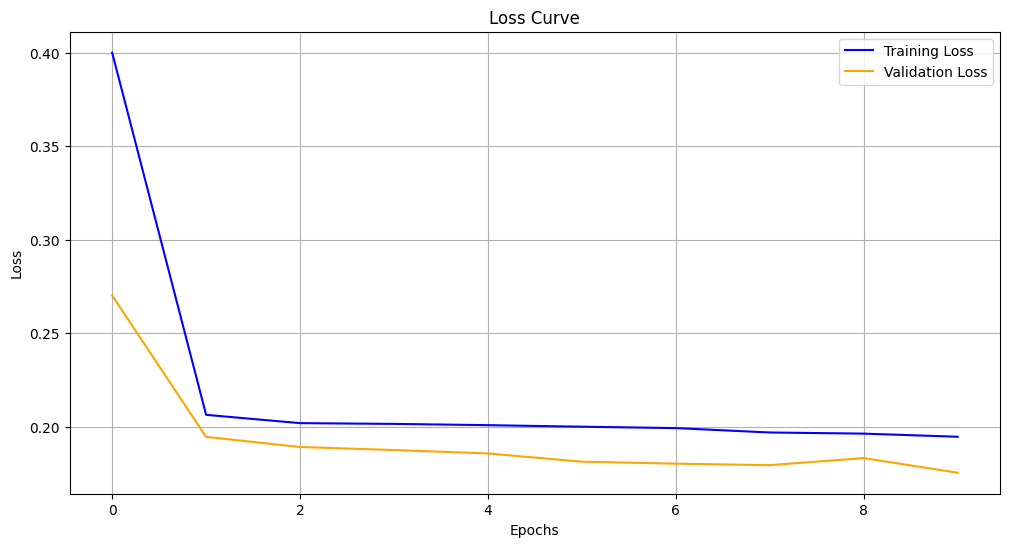

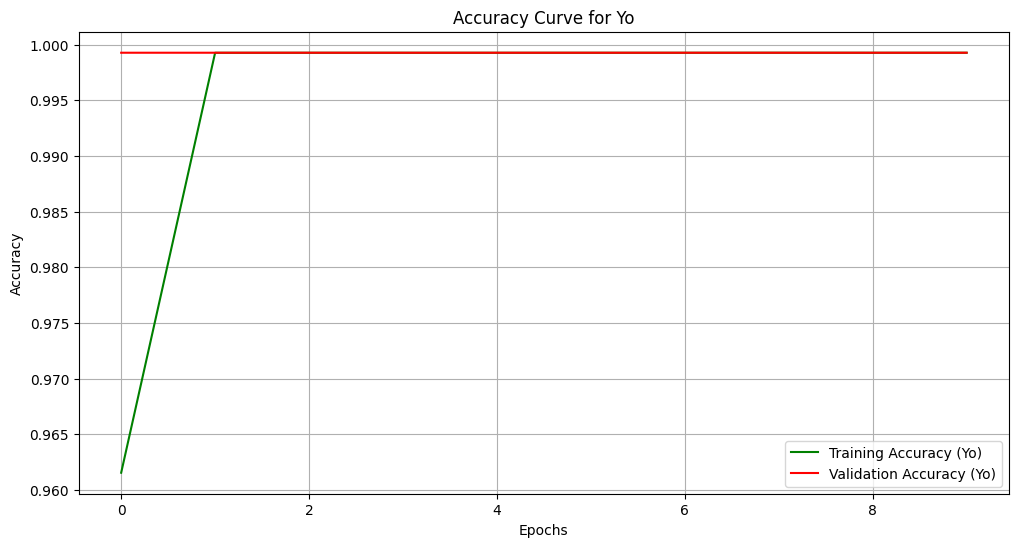

In [7]:
# Courbes de perte
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Courbes d'exactitude (Yo uniquement, par exemple)
if "Yo_accuracy" in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history["Yo_accuracy"], label="Training Accuracy (Yo)", color="green")
    plt.plot(history.history["val_Yo_accuracy"], label="Validation Accuracy (Yo)", color="red")
    plt.title("Accuracy Curve for Yo")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


In [71]:

# Répertoires des fichiers audio et labels
audio_test_dir = "Dataset/test/audio"
label_test_dir = "Dataset/test/matrices"
batch_size = 16

# Étape 1 : Charger les noms de fichiers audio
#test_files = sorted([f for f in os.listdir(audio_test_dir) if f.endswith('.wav')])


# Étape 3 : Initialiser les générateurs avec les répertoires et les fichiers sélectionnés
test_generator = DataGenerator(
    audio_dir=audio_test_dir,
    label_dir=label_test_dir,
    batch_size=batch_size,
    segment_duration=2.0,
    sr=22050
)
#test_subset = test_files[:8]
#test_generator.audio_files = test_subset  # Limiter aux fichiers val

print(f"Nombre de pistes de test : {len(test_generator)}")



Nombre de pistes de test : 36


In [66]:

# Charger le meilleur modèle sauvegardé
best_model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"WeightedBinaryCrossEntropy": WeightedBinaryCrossEntropy}
)

# Évaluer le modèle
val_loss, val_Yo_loss, val_Yn_loss, val_Yp_loss, val_Yo_acc, val_Yn_acc, val_Yp_acc = best_model.evaluate(test_generator)

# Afficher les résultats
print(f"Validation Loss: {val_loss}")
print(f"Validation Loss (Yo): {val_Yo_loss}, Accuracy (Yo): {val_Yo_acc}")
print(f"Validation Loss (Yn): {val_Yn_loss}, Accuracy (Yn): {val_Yn_acc}")
print(f"Validation Loss (Yp): {val_Yp_loss}, Accuracy (Yp): {val_Yp_acc}")


566/566 [==============================] - 403s 711ms/step - loss: 0.1823 - Yo_loss: 0.0036 - Yn_loss: 0.0791 - Yp_loss: 0.0997 - Yo_accuracy: 0.9993 - Yn_accuracy: 0.9820 - Yp_accuracy: 0.9817
Validation Loss: 0.18231290578842163
Validation Loss (Yo): 0.0035742572508752346, Accuracy (Yo): 0.9992876648902893
Validation Loss (Yn): 0.0790606364607811, Accuracy (Yn): 0.9819736480712891
Validation Loss (Yp): 0.09967798739671707, Accuracy (Yp): 0.9816832542419434


## Prédiction

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
from compute_harmonic_cqt import compute_harmonic_cqt   

# Load the trained model
MODEL_PATH = "best_model_weighted_full.keras"
best_model = tf.keras.models.load_model(MODEL_PATH)

# Load a 2-second audio example, for example, segment_1 of 00_Jazz2-187-F#_solo_hex_cln
audio_path = r"data_test\00_Jazz2-187-F#_solo_hex_cln\segments\segment_1.wav"
segment, _ = librosa.load(audio_path, sr=22050)

# To compute the CQT and apply harmonic stacking
cqt_harmonic_flattened = self.compute_harmonic_cqt(segment)

# Make predictions
predictions = best_model.predict(cqt_harmonic_flattened)
Yo = predictions[0]
Yn = predictions[1]
Yp = predictions[2]

# Visualize the results
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(Yo, aspect='auto', origin='lower', cmap='hot', vmin=0, vmax=1)
plt.colorbar(label="Value")
plt.title("Yo (Note Onsets)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.subplot(1, 3, 2)
plt.imshow(Yn, aspect='auto', origin='lower', cmap='hot', vmin=0, vmax=1)
plt.colorbar(label="Value")
plt.title("Yn (Note Activations)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.subplot(1, 3, 3)
plt.imshow(Yp, aspect='auto', origin='lower', cmap='hot', vmin=0, vmax=1)
plt.colorbar(label="Value")
plt.title("Yp (Multi-Pitch Estimate)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.tight_layout()
plt.show()

## Post processing

In [ ]:
from post_processing import post_process_note_events

# Post-process
predicted_note_events, predicted_matrix_note_events = post_process_note_events(Yo, Yn)

# Plot binary note events after post-processing
plt.figure(figsize=(12, 10))
plt.imshow(predicted_matrix_note_events, aspect='auto', origin='lower', cmap='Greys', vmin=0, vmax=1)
plt.colorbar(label="Value")
plt.title("Note Events (Post-processed)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")
plt.show()

## Evaluation of Metrics

In [ ]:
import numpy as np
import os
import pandas as pd

# Load the ground truth data for a segment, for example, segment_1 of 00_Jazz2-187-F#_solo_hex_cln
segment_folder = r"...\data_test\00_Jazz2-187-F#_solo_hex_cln\segments"
id = "segment_1"
audio_path = os.path.join(segment_folder, f"{id}.wav")   # The 2-second audio
matrix_note_events_path = os.path.join(segment_folder, f"{id}.npy")   # The .npy file containing the note activation matrix
note_events_path = os.path.join(segment_folder, f"{id}.csv")   # The .csv file containing note events in the form (t_start, t_end, note)

# Load the associated files
truth_matrix_note_events = np.load(matrix_note_events_path)
truth_note_events = pd.read_csv(note_events_path)

## Post-process predicted results Yo and Yn (if not already done)
#predicted_note_events, predicted_matrix_note_events = post_process_note_events(Yo, Yn)

# Convert the results into a format compatible with metrics calculation
predicted_note_events_metric = {
    "intervals": [(note[0], note[1]) for note in predicted_note_events],  # Extract t^0 and t^1
    "pitches": [note[2] for note in predicted_note_events]  # Extract f (pitch)
}
truth_note_events_metric = {
    "intervals": [(row["time"], row["time"] + row["duration"]) for _, row in truth_note_events.iterrows()],
    "pitches": truth_note_events["note"].tolist()
}

# Calculating the metrics
metrics = calculate_metrics(truth_note_events_metric, predicted_note_events_metric, truth_matrix_note_events.T, predicted_matrix_note_events)
print(metrics)